Rohan Bhatt - MSML604 HW7

In [6]:
#problem 1
import numpy as np
import matplotlib.pyplot as plt

#defining the problem data, setting all types to floats for numpy calc purposes
P = np.array([[5, 4, 6],
              [4, 9, 15],
              [6, 15, 35]], dtype=float)
q = np.array([5, 7, 6], dtype=float)
#initial point
x0 = np.array([2, 4, 6], dtype=float) 

#defining f(x) as stated in the problem:
def f(x):
    return .5*x @ P @ x + q @ x
#defining the gradient of f(x)
def grad(x):
    return P @ x + q

#part a (armijo backtracking)
def gradient(x0, alpha_init=2, gamma=0.5, beta=0.8, tol=1e-10, max_iterations=2_000, verbose = False): #putting alpha gamma beta in the parameters, along with the tolerance for convergence
    x = x0.copy().astype(float) #copying the initial point
    f_hist = [f(x)]
    for k in range(max_iterations):
        g = grad(x) #current gradient
        #stopping test
        if np.linalg.norm(g) < tol:
            if verbose:
                print(f"Converged ‖∇f‖={np.linalg.norm(g):.2e} at k={k}")
            break
        #armijo line search
        alpha = alpha_init #starting with a_initi
        #condition is f( x - alpha*g) <= f(x) - beta*alpha*np.linalg.norm(g)**2
        while f(x - alpha * g) > f(x) - beta * alpha * (g @ g):
            alpha *= gamma # shrink α ← γ α
            #print(f"alpha: {alpha}")

        #gradient descent step
        x = x - alpha * g
        f_hist.append(f(x))
        if verbose:
            print(f"Iteration {k}: x = {x}, f(x) = {f_hist[-1]}, alpha = {alpha}")
    return x, f_hist
x_gd, vals_gd  = gradient(x0)
print(x_gd)
print(vals_gd)


[-0.47552474 -1.45804146  0.53496488]
[1250.0, 552.8991088867188, 246.40335679613054, 111.4582507259953, 51.868383038838886, 25.3898412071853, 13.4706500110642, 7.962815126964439, 5.287146159918638, 3.8708365253636923, 2.3585350323278993, 0.858972922453785, -1.1854568636975578, -1.8496239591138455, -2.786204554567642, -3.0992187653522842, -3.559203771261725, -3.8511756087051845, -3.9653158515030946, -4.132686327200712, -4.1988704503834455, -4.384813523556018, -4.407289454475465, -4.459876600199643, -4.48419966190033, -4.522109689535977, -4.538752556091924, -4.589345777796741, -4.595845512021236, -4.612294329859623, -4.619898532518272, -4.6419947173323655, -4.645446191778517, -4.652795223784529, -4.654831347007811, -4.660677880577259, -4.663285830689557, -4.671288437237958, -4.672327984109974, -4.674972701461016, -4.676196627922374, -4.679767589811057, -4.680321686630741, -4.681512198681222, -4.6818405066407625, -4.682787670111343, -4.683209713607562, -4.684507403138258, -4.684674828298

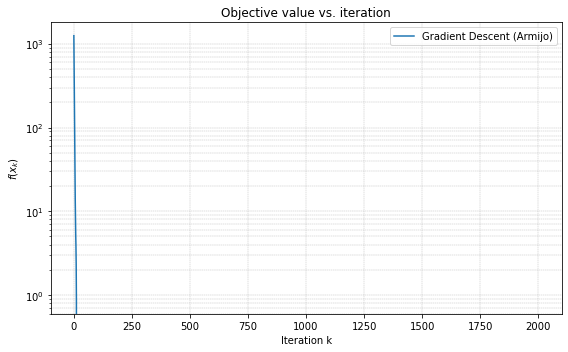

In [ ]:
#plots for all parts:
plt.figure(figsize=(8,5))
plt.semilogy(vals_gd,  label="Gradient Descent (Armijo)")
# plt.semilogy(vals_cg,  label="Conjugate Gradient")
# plt.semilogy(vals_new, label="Newton")
# plt.semilogy(vals_dfp, label="DFP")
# plt.semilogy(vals_bfgs,label="BFGS")
plt.xlabel("Iteration k")
plt.ylabel(r"$f(x_k)$")
plt.title("Objective value vs. iteration")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.4)
plt.tight_layout()
plt.show()